# Extract Edges from road data

In [21]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, Point, MultiPoint
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import split
from haversine import haversine
import pickle 

In [3]:
#path of road data
road_file = "data/berlin-latest-free/gis_osm_roads_free_1.shp"
#read road data
gdf_road = gpd.read_file(road_file)
print("Number of roads: ", len(gdf_road))

Number of roads:  189459


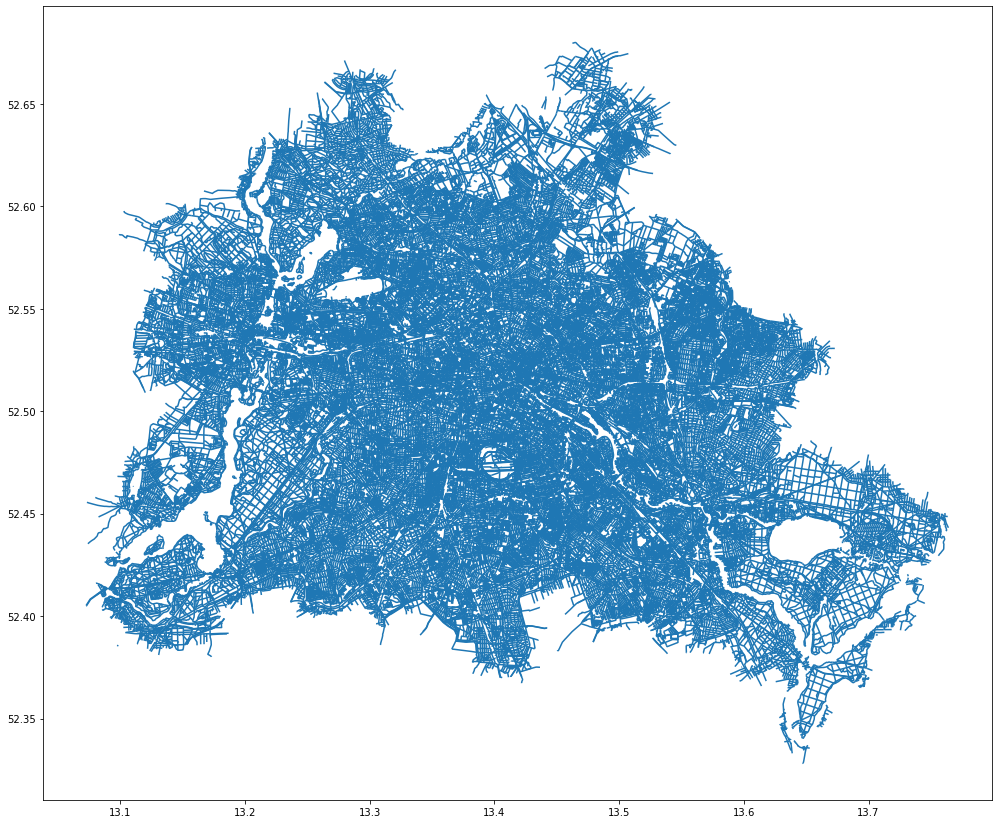

In [4]:
gdf_road.plot(figsize=(17,17))
plt.show()

In [6]:
print(gdf_road.columns)
print("Maxspeed of roads: ", np.unique(gdf_road["maxspeed"]))

Index(['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed',
       'layer', 'bridge', 'tunnel', 'geometry'],
      dtype='object')
Maxspeed of roads:  [  0   3   5   6   7   8  10  15  17  20  30  40  50  60  70  80 100 120]


In [9]:
#define condition to filter roads
for_cars = ((gdf_road.fclass=="motorway")|(gdf_road.fclass=="trunk")|\
           (gdf_road.fclass=="primary")|(gdf_road.fclass=="secondary")|(gdf_road.fclass=="tertiary"))&\
            (gdf_road.maxspeed>=3)

In [10]:
gdf_road_cars = gdf_road[for_cars]
print("Number of filtered roads: ", len(gdf_road_cars))

Number of filtered roads:  14257


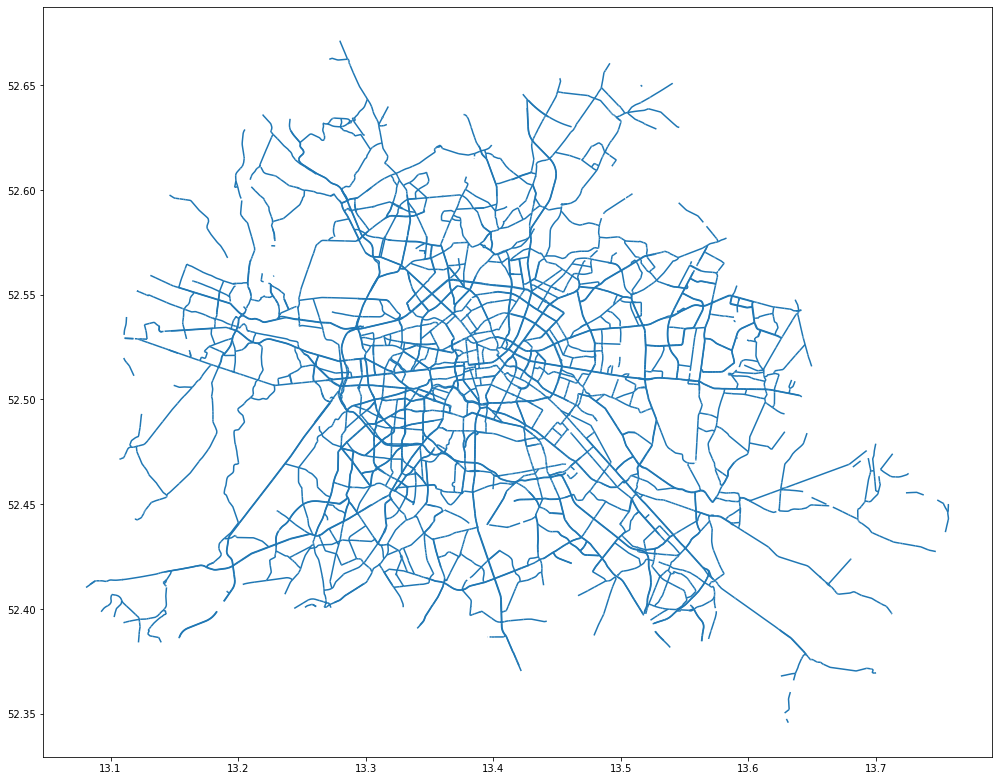

In [11]:
gdf_road_cars.plot(figsize=(17,17))
plt.show()

In [12]:
def get_intersections(lines):
    """
    get intersections of the lines(roads) 
    these intersections will be roads network
    arg: lines: the array of roads(LineStrings)
    return: intersections
    """
    point_intersections = []
    line_intersections = []
    lines_len = len(lines)
    for i in range(lines_len-1):
        for j in range(i+1,lines_len):
            l1,l2 = lines[i],lines[j]
            if l1.intersects(l2):
                intersection=l1.intersection(l2)
                if isinstance(intersection, LineString):
                     line_intersections.append(intersection)
                     inter_list = list(intersection.coords)
                     inter_list_points = [Point(p) for p in inter_list]
                     point_intersections+=inter_list_points
                elif isinstance(intersection, Point):
                     point_intersections.append(intersection)
                elif isinstance(intersection, MultiPoint):
                    points_ij = [Point(p.x,p.y) for p in intersection]
                    point_intersections+=points_ij
    return point_intersections, line_intersections

In [14]:
roads = gdf_road_cars["geometry"].values #extract roads 
point_intersections, line_intersections = get_intersections(roads)

In [17]:
point_intersections_coords = list(set([(p.x,p.y) for p in point_intersections]))
#get the unique point coords
point_intersections = [Point(p) for p in point_intersections_coords]
#get the unique point intersections
print("Number of intersection points: ",len(point_intersections))

Number of intersection points:  12656


In [20]:
#save intersections points' coordinates
with open("./points_intersection_coords.pkl","wb") as f:
    pickle.dump(point_intersections_coords, f)

In [21]:
with open("./points_intersection_coords.pkl", "rb") as f:
    point_intersections_coords_test = pickle.load(f)

In [18]:
#find corresponding points on road
road_points = []
road_points_coords = []
for road in roads:
    points_i = []
    points_i_coords = []
    for p in point_intersections:
        if p.distance(road)==0:
            points_i.append(p)
            points_i_coords.append((p.x,p.y))
    road_points.append(points_i)
    road_points_coords.append(points_i_coords)

In [26]:
#save roads and points on the road
with open("./road_points_coords.pkl","wb") as f:
    pickle.dump(road_points_coords, f)

In [27]:
with open("./road_points_coords.pkl", "rb") as f:
    road_points_coords_test = pickle.load(f)

In [32]:
#compute haversine distance of edges(links)
def compute_haver_link(link):
    length = len(link)
    h_distance = 0
    i=0
    j=1
    while(j<length):
        h_distance+=haversine(link[i],link[j])
        i+=1
        j+=1
    return h_distance

In [33]:
#compute edges of road and the haversine distance of the edge

road_edges = [] #[[(),(),()]]
h_distances = []

for i in range(len(road_points)):
    road_edges_i = []
    h_distances_i = []
    road = roads[i]
    road_points_i = road_points[i]
    if road_points_i!=[]:
        point_i = MultiPoint(road_points_i)
        result_i = split(road, point_i)
        for j in range(len(result_i)):
            link_ij_coords = list(result_i[j].coords)
            link_ij = (link_ij_coords[0],link_ij_coords[-1])
            h_distances_i.append(compute_haver_link(link_ij_coords))
            road_edges_i.append(link_ij)
    road_edges.append(road_edges_i)
    h_distances.append(h_distances_i)

In [37]:
#save edges and corresponding distances on road
with open("./road_edges.pkl","wb") as f:
    pickle.dump(road_edges, f)
with open("./h_distances.pkl","wb") as f:
    pickle.dump(h_distances, f)

In [41]:
# extract maxspeeds of roads
maxspeeds = gdf_road_cars.maxspeed.values

In [54]:
#extract maxspeed of edges
maxspeed_of_edges = []
road_edges_all = []
for i in range(len(road_edges)):
    road_edges_all+=road_edges[i]
    num_edges = len(road_edges[i])
    maxspeed_of_edges+=[maxspeeds[i]]*num_edges
h_distances_all = []
for distance in h_distances:
    h_distances_all+=distance

In [56]:
# save edges and corresponding properties(maxspeed, haversine_distances)
with open("./maxspeed_of_edges.pkl","wb") as f:
    pickle.dump(maxspeed_of_edges, f)
with open("./road_edges_all.pkl","wb") as f:
    pickle.dump(road_edges_all, f)
with open("./h_distances_all.pkl","wb") as f:
    pickle.dump(h_distances_all, f)

# Build Road Network

In [2]:
import networkx as nx
from graph_tool.all import *
from graph_tool.topology import shortest_path
from graph_tool import PropertyMap, EdgePropertyMap
from networkx.algorithms.shortest_paths.generic import shortest_path as nx_shortest_path
import pickle

In [2]:
with open("./result/maxspeed_of_edges.pkl","rb") as f:
    maxspeed_of_edges=pickle.load(f)
with open("./result/road_edges_all.pkl","rb") as f:
    road_edges_all = pickle.load(f)
with open("./result/h_distances_all.pkl","rb") as f:
    h_distances_all = pickle.load(f)

In [3]:
dict_edges_hdistances = dict(zip(road_edges_all,h_distances_all))
dict_edges_maxspeeds = dict(zip(road_edges_all, maxspeed_of_edges))

In [4]:
g = nx.Graph()
g.add_edges_from(road_edges_all)
print("Number of nodes: ", g.number_of_nodes())
print("Number of edges: ",g.number_of_edges())

Number of nodes:  12665
Number of edges:  14803


In [5]:
edges_g = list(g.edges())
hdistances_g = []
maxspeeds_g = []
for edge in edges_g:
    if edge in dict_edges_hdistances.keys():
        hdistances_g.append(dict_edges_hdistances[edge])
        maxspeeds_g.append(dict_edges_maxspeeds[edge])
    else:
        hdistances_g.append(dict_edges_hdistances[(edge[1],edge[0])])
        maxspeeds_g.append(dict_edges_maxspeeds[(edge[1],edge[0])])

In [6]:
for i in range(len(edges_g)):
    edge = edges_g[i]
    hdistance = hdistances_g[i]
    maxspeed = maxspeeds_g[i]
    g[edge[0]][edge[1]]["hdistance"]=hdistance
    g[edge[0]][edge[1]]["maxspeed"]=maxspeed

In [7]:
largest_cc = max(nx.connected_components(g), key=len)
g_con = g.subgraph(largest_cc).copy()

In [13]:
#reindex nodes
#connected_nodes_coords = list(g_con.nodes)
dict_coords_nodes = dict(zip(connected_nodes_coords, range(len(connected_nodes_coords))))
dict_nodes_coords = dict(zip(range(len(connected_nodes_coords)),connected_nodes_coords))

In [60]:
#save dictionary of nodes
with open("dict_coords_nodes.pkl","wb") as f:
    pickle.dump(dict_coords_nodes,f)
with open("dict_nodes_coords.pkl","wb") as f:
    pickle.dump(dict_nodes_coords,f)

In [14]:
g_con = nx.relabel.relabel_nodes(g_con, dict_coords_nodes)

In [ ]:
#create road network with graph tool

In [19]:
connected_edges = list(g_con.edges)
connected_edges_property = []
for edge in connected_edges:
    hdistance = g_con.get_edge_data(edge[0],edge[1])["hdistance"]
    maxspeed = g_con.get_edge_data(edge[0],edge[1])["maxspeed"]
    edge_property = list(edge)
    edge_property.append(hdistance)
    edge_property.append(maxspeed)
    connected_edges_property.append(edge_property)

In [45]:
road_network = Graph(directed=False)
hdistance_edge = road_network.new_edge_property("double")
maxspeed_edge = road_network.new_edge_property("double")
road_network.add_edge_list(connected_edges_property, eprops=[hdistance_edge,maxspeed_edge])
road_network.edge_properties["hdistance"] = hdistance_edge
road_network.edge_properties["maxspeed"] = maxspeed_edge

In [46]:
#save road network
road_network.save("road_network.xml.gz")

In [22]:
test = load_graph("./result/road_network.xml.gz")
hdistance_edge = test.edge_properties["hdistance"]
maxspeed_edge = test.edge_properties["maxspeed"]

In [24]:
test.num_vertices()

12225

In [26]:
hdistances = [edge_hdistance[e] for e in list(test.edges())]
sum(hdistances)/len(hdistances)

0.1862453577550753

In [28]:
C = (20000)/(0.19*22.1*2)
C

2381.519409383186

In [53]:
31584/(48*25*2)

13.16

In [34]:
edge_maxspeed = test.edge_properties["maxspeed"]

In [35]:
maxspeeds = [edge_maxspeed[e] for e in edges]

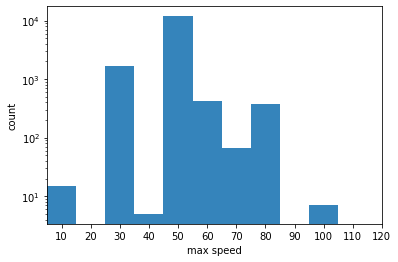

In [51]:
import matplotlib.pyplot as plt
bins = np.arange(10,130,10)-5
fig,ax = plt.subplots()
ax.set_xlim([min(maxspeeds)-5, max(maxspeeds)+5])
ax.hist(maxspeeds, bins=bins, alpha=0.9)
ax.set_yscale("log")
ax.set_xticks(np.arange(10,130,10))
ax.set_xlabel("max speed")
ax.set_ylabel("count")
plt.show()

In [52]:
max(maxspeeds)

100.0

compare compute shortest distance

In [7]:
#compute shortest path with graph-tool
%timeit shortest_path(test,0,100, weights=hdistance_edge)

11.1 ms ± 876 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
test.edge_properties

{'hdistance': <EdgePropertyMap object with value type 'double', for Graph 0x7f8fe4926d50, at 0x7f8fe5d71b50>, 'maxspeed': <EdgePropertyMap object with value type 'double', for Graph 0x7f8fe4926d50, at 0x7f8fe97d8510>, 'mintime': <EdgePropertyMap object with value type 'double', for Graph 0x7f8fe4926d50, at 0x7f8feaa2ca90>}

In [14]:
edge_hdistance = test.edge_properties["hdistance"]

In [16]:
edges = list(test.edges())
hdistances_of_edges = [edge_hdistance[e] for e in edges]

In [12]:
nodes,path = shortest_path(test,0,100, weights=hdistance_edge, negative_weights=True)
distance = sum([hdistance_edge[e] for e in path])
distance

20.306825931695666

In [51]:
#compute shortest path with networkx
%timeit nx_shortest_path(g_con, 0, 100, weight="hdistance" )

39.3 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Project centroids to nodes on road network

In [138]:
import pandas as pd
import pickle
from shapely.geometry import Point
from haversine import haversine
import numpy as np

In [73]:
#read centroids from file
df_centroids = pd.read_csv("./result/centroids_berlin.tsv", sep='\t')
df_centroids.head()

,Centroid_ID,Longitude,Latitude
0,0,13.420105,52.512959
1,1,13.454981,52.477553
2,2,13.449665,52.516822
3,3,13.416853,52.546727
4,4,13.388138,52.527635


In [117]:
#get coordinates and generate points of the centroids
lons_centroid = df_centroids["Longitude"].values #extract longitudes of centroids
lats_centroid = df_centroids["Latitude"].values #extract latitudes of centroids
coordinates_centroid = list(zip(lons_centroid,lats_centroid))
#points_centroid = [Point(p) for p in coordinates_centroid]

In [119]:
#load coordinates of nodes
with open("./result/dict_coords_nodes.pkl","rb") as f:
    dict_coords_nodes = pickle.load(f)

In [120]:
coords_nodes = list(dict_coords_nodes.keys())

In [92]:
coords_nodes_points = [Point(p) for p in coords_nodes]

In [121]:
centroids_project_nodes = [] #record centroids_project_nodes
min_distances = [] #record min distances
for centroid in coordinates_centroid:
    #get point of centroid
    min_distance = haversine(centroid,coords_nodes[0])
    #compute distance as mindistance
    node_projected = coords_nodes[0]
    for coord_node in coords_nodes:
        current_distance = haversine(centroid,coord_node)
        if current_distance<min_distance:
            #update min distance and projected node
            min_distance = current_distance
            node_projected = coord_node
    min_distances.append(min_distance)
    centroids_project_nodes.append(node_projected)

In [124]:
#get nodes_id of road network
centroid_project_nodes_ids = [dict_coords_nodes[p] for p in centroids_project_nodes]

In [135]:
#extract longitudes and latitudes from projected nodes
centroids_project_lons = [n[0] for n in centroids_project_nodes]
centroids_project_lats = [n[1] for n in centroids_project_nodes]

In [136]:
#extract centroid id
centroids_ids = df_centroids["Centroid_ID"].values

In [140]:
#create dataframe
df_centroid_project = pd.DataFrame()
df_centroid_project["Centroid_ID"] = centroids_ids
df_centroid_project["Centroid_Lon"] = lons_centroid
df_centroid_project["Centroid_Lat"] = lats_centroid
df_centroid_project["Project_ID"] = np.array(centroid_project_nodes_ids)
df_centroid_project["Projected_Lon"] = np.array(centroids_project_lons)
df_centroid_project["Projected_Lat"] = np.array(centroids_project_lats)
df_centroid_project["Projected_Distance"] = np.array(min_distances)

In [141]:
df_centroid_project.head()

,Centroid_ID,Centroid_Lon,Centroid_Lat,Project_ID,Projected_Lon,Projected_Lat,Projected_Distance
0,0,13.420105,52.512959,5837,13.419641,52.514961,0.222594
1,1,13.454981,52.477553,7929,13.453208,52.475297,0.313691
2,2,13.449665,52.516822,1731,13.452461,52.515884,0.327107
3,3,13.416853,52.546727,7406,13.416371,52.547169,0.071742
4,4,13.388138,52.527635,9053,13.388463,52.527408,0.043650


In [144]:
#Save the data
df_centroid_project.to_csv("./centroids_berlin_projected.tsv", index=False, sep='\t')